# Portfolio optimization - Maximum Sharpe Portfolio

Mean Variance Optimization solves for the optimial portfolio given a risk aversion parameter $\gamma$. Instead of specifying a risk aversion parameter one might one to solve for the a portfolio which maximizes the Sharpe ratio (ratio of expected return in units of expected risk)

In this notebook we
1. Solve the Mean-Variance Portfolio for various values of gamma, to find the maximum Sharpe ratio portfolio
2. Solve the Maximum Sharpe ratio portfolio directly

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Generate data for long only portfolio optimization.
np.random.seed(1)
n = 10
mu = np.abs(np.random.randn(n, 1))
Sigma = np.random.randn(n, n)
Sigma = Sigma.T.dot(Sigma)

r_free = 0.05

## Classical (Markowitz) portfolio optimization

Classical (Markowitz) portfolio optimization solves the optimization problem

$$
\begin{array}{ll} \text{maximize} & \mu^T w - \gamma w^T\Sigma w\\
\text{subject to} & {\bf 1}^T w = 1, \quad w \in {\cal W},
\end{array}
$$

where $w \in {\bf R}^n$ is the optimization variable, $\cal W$ is a set of allowed portfolios (e.g., ${\cal W} = {\bf R}_+^n$ for a long only portfolio), and $\gamma >0$ is the *risk aversion parameter*.

The objective $\mu^Tw - \gamma w^T\Sigma w$ is the *risk-adjusted return*. Varying $\gamma$ gives the optimal *risk-return trade-off*.
We can get the same risk-return trade-off by fixing return and minimizing risk.

In [3]:
# Long only portfolio optimization.
w = cp.Variable(n)
gamma = cp.Parameter(nonneg=True)
ret = mu.T @ w
risk = cp.quad_form(w, Sigma)
prob_mean_variance = cp.Problem(cp.Maximize(ret - gamma * risk), [cp.sum(w) == 1])

In [4]:
SAMPLES = 100
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-1, 2, num=SAMPLES)
w_data = np.zeros((SAMPLES,n))
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob_mean_variance.solve()
    risk_data[i] = cp.sqrt(risk).value
    ret_data[i] = ret.value[0]
    w_data[i] = w.value


Text(0, 0.5, 'Sharpe ratio')

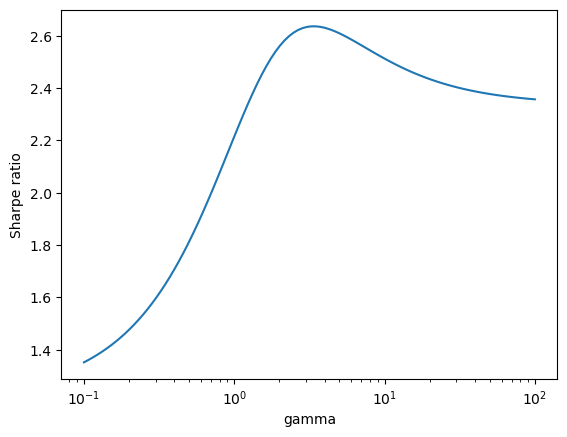

In [5]:
sharpe_data = (ret_data-r_free)/risk_data
max_i = np.argmax(sharpe_data)
plt.plot(gamma_vals, sharpe_data)
plt.xscale('log')
plt.xlabel('gamma')
plt.ylabel('Sharpe ratio')

## Maximum Sharpe Ratio Portfolio

The maximum Sharpe ratio optimization solve the problem

$$
\begin{array}{ll} \text{maximize} & \frac{\mu^T x - r_{f}}{\sqrt{x^T\Sigma x}}\\
\text{subject to} & {\bf 1}^T x = 1
\end{array}
$$

In this current form this is a non-convex problem. However we can use an auxiliary parameter $\kappa$ and solve a related problem in terms of $y = x\kappa$


$$
\begin{array}{ll} \text{minimize} & y^T\Sigma y\\
\text{subject to} & ({r-r_f})^T y = 1\\
& {\bf{1}}^T y = \kappa
\end{array}
$$
The optimal portfolio is $x^* = \frac{y^*}{\kappa}$


Links
* https://quant.stackexchange.com/questions/39594/maximize-sharpe-ratio-in-portfolio-optimization
* https://quant.stackexchange.com/questions/39137/how-can-i-find-the-portfolio-with-maximum-sharpe-ratio-using-lagrange-multipli


In [6]:
y = cp.Variable(n)
kappa = cp.Variable(1)
risk_y = cp.quad_form(y, Sigma)
prob_max_sharpe = cp.Problem(cp.Minimize(risk_y),[(mu - r_free).T @ y==1,cp.sum(y)==kappa ])
prob_max_sharpe.solve()

x = y.value/kappa.value

max_sharpe = 1/np.sqrt(risk_y.value)

Max Sharpe Ratio Solution

In [7]:
max_sharpe, np.round(x,3)

(2.6362178656800963,
 array([ 0.093, -0.091,  0.288,  0.109,  0.025,  0.193,  0.092,  0.013,
         0.121,  0.156]))

Best Mean-Variance Solution

In [8]:
sharpe_data[max_i], np.round(w_data[max_i],3)

(2.6360151469107675,
 array([ 0.091, -0.092,  0.284,  0.112,  0.028,  0.197,  0.093,  0.011,
         0.121,  0.155]))

## Special Case: Diagonal Matrix

In [9]:
Sigma_diag = np.diag(np.diag(Sigma))

## Analytical solution:

$$ w_i \sim \frac{(r_i-r_f)}{\sigma_i^2} = \frac{sr_i}{\sigma_i} $$

The portfolio Sharpe Ratio is the L2 norm of the individual Sharpe Ratios

$$ sr_P = \sqrt{\sum_i sr_i^2} $$

Link: https://quant.stackexchange.com/questions/63944/optimise-the-sharpe-ratio-of-a-portfolio-of-uncorrelated-assets

In [10]:
sharpe_ratios = (mu[:,0]-r_free)/np.sqrt(np.diag(Sigma_diag))
w_diag = sharpe_ratios/np.sqrt(np.diag(Sigma_diag))
w_diag = w_diag/w_diag.sum()

In [11]:
port_sharpe = np.sqrt((sharpe_ratios**2).sum())
port_sharpe

1.47880186597961

In [12]:
y_diag = cp.Variable(n)
kappa_diag = cp.Variable(1)
risk_y_diag = cp.quad_form(y_diag, Sigma_diag)
prob_max_sharpe_diag = cp.Problem(cp.Minimize(risk_y_diag),[(mu - r_free).T @ y_diag==1,cp.sum(y_diag)==kappa_diag ])
prob_max_sharpe_diag.solve()

x_diag = y_diag.value/kappa_diag.value

max_sharpe_diag = 1/np.sqrt(risk_y_diag.value)

In [13]:
max_sharpe_diag, x_diag

(1.47880186597961,
 array([0.12050461, 0.03559165, 0.07825948, 0.11036125, 0.11903948,
        0.21756976, 0.23786194, 0.04094803, 0.02077194, 0.01909183]))

In [14]:
w_diag

array([0.12050461, 0.03559165, 0.07825948, 0.11036125, 0.11903948,
       0.21756976, 0.23786194, 0.04094803, 0.02077194, 0.01909183])